## how long until I get into the Hardrock 100?

The Hardrock 100 is a 100-mile footrace through the San Juan mountains of Colorado.  It is considered a "post-graduate level" event with 66000 feet elevation change and an average elevation of over 11000 ft!  It is one of my lifelong goals to run in this event.  

Hardrock is a small event and maintains a lottery system to gain entry.  Runners must run a qualifier race in order to enter the lottery.  They allot 45 slots in the lottery each year to newcomers.  Based on the calculations of the Hardrock organizers, each newcomer gets 2^n tickets in the lottery, where n is the number of DNSs (did not start) from all previous years.  So, if you have tried and failed to get into the race for several years, then your chances of getting in go up dramatically.  

I wanted to figure out how long it would take me to have a good chance of getting into HR100.  To do this, I utilized lottery data the organizers (Blake Wood) nicely release for the last three years.  Blake uses simulation to predict what the odds of newcomers with x number of tickets in the lottery.  Using this data, I decided to build a simple probabilistic model using PyMC of my entrance into the lottery process.  

**TL;DR: It's going to take around 10 years.**  



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import numpy as np
from scipy import stats

%matplotlib inline

I transferred the lottery odds data from the PDF reports from the last three years to a CSV for easy read to python.

In [25]:
data = pd.read_csv('./hr100_odds.csv',header=0,index_col=0)

In [26]:
data

,2017,2018,2019,2017_chance,2018_chance,2019_chance
tix,,,,,,
1,736,739,778,0.6,0.4,0.3
2,435,526,552,1.2,0.9,0.6
4,252,284,340,2.4,1.7,1.1
8,177,201,229,4.7,3.4,2.3
16,73,128,155,9.2,6.7,4.5
32,42,64,104,17.6,13.2,8.8
64,10,27,45,32.2,24.4,16.8
128,1,6,18,54.1,42.6,30.8
256,0,0,1,NaN,NaN,52.3


In [27]:
# calculate total number of tickets per lottery year
total_tix = []
for x in ['2017','2018','2019']:
    
    total_tix.append((data[x]*data.index).sum())

([<matplotlib.axis.XTick at 0x7f52b1f0cad0>,
 <a list of 3 Text xticklabel objects>)

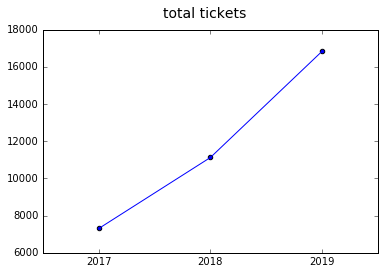

In [28]:
plt.plot(total_tix)
plt.scatter([0,1,2],total_tix)
plt.suptitle('total tickets',size=14)
plt.xticks([0,1,2],[2017,2018,2019])

The total number of tickets appears to be increasing linearly, so a linear model seems like a decent first approximation of the process.  So we'll start with that in the model below.  

### model assumptions: 
* the total number of tickets increases linearly over time.  Likely this is not true and I expect it will plateau at a given number, or even increase at greater than linear rates.  More modeling to come on this.  
* each year, I model my number of tickets as a binomial distribution with p = 0.90, meaning  each uear I expect there'sa 90% chance I'll qualify to enter the lottery.  That is a huge assumption, essentially saying in 5 years I think I'll be healthy, fit, and have enough time to run a 100 mile race.  Oof...

### the model:
1. Normal linear regression model inferring values of the slope and intercept based on our available data.  Use that model to build a distribution of what we think the total number of tickets will look like each year into the future.  
2. My number of tickets each year is a binomial distribution with p = 0.90 and n = year - 2019.  
3. The output of the model is a geometric distribution showing how many draws from the lottery are necessary until my name gets picked the first time.  Since there are (currently) 45 draws for newbies, then if that number is less than 45, I expect to get picked!

In [6]:
# years to predict

ytp = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
ytp_real = 2017+ytp
print ytp_real

[2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034
 2035]


In [8]:
b0 = pymc.Normal('b0',7000,0.00001) # intercept of model of total tickets in lottery
b1 = pymc.Normal('b1',5000,0.00001) # slope of total_tickets linear model

err= pymc.Uniform('err',0,500) # error on total_tickets model

x=np.array([0,1,2]) 

# distribution of number of tickets per year with 0.9 prob of drawing 1 tix per year
my_tickets = pymc.Binomial('num tix',p=0.9,n=np.array([ytp-1])) 

# the model
@pymc.deterministic
def total_pool_pred(b0=b0,b1=b1,x=x):
    return b0+b1*x

#estimate values of the model based on data
total_pool = pymc.Normal('y', total_pool_pred , err, value=np.array(total_tix), observed=True)

# use fitted params to estimate population size at each year
pop_size = pymc.Normal('population',mu=b1*ytp+b0,tau=err,size=len(ytp))


def chance_final(foonum=my_tickets,pop_size=pop_size):
    tmp = (2**foonum)/pop_size
    tmp[tmp>1] = 1
    return tmp

chances = pymc.Deterministic(name='chances',eval=chance_final,parents={"foonum":my_tickets,"pop_size":pop_size},doc='foo')
                            
# how many draws until success,                              
final = pymc.Geometric('final_odds',p=chances)


model = pymc.Model([total_pool_pred, b0, b1, total_pool, err, x,pop_size,chances,my_tickets,final])


In [9]:
mcmc = pymc.MCMC(model)
mcmc.sample(100000, 20000)

/home/adam/anaconda2/lib/python2.7/site-packages/pymc/StepMethods.py:782: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


 [-----------------100%-----------------] 100000 of 100000 complete in 25.9 sec

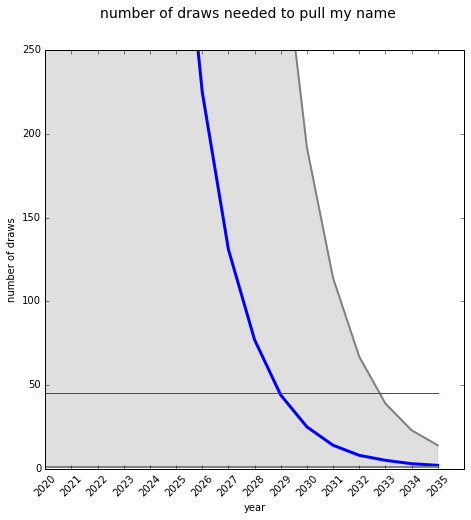

In [30]:
fo_central = final.stats()['quantiles'][50]
fo_ub = final.stats()['95% HPD interval'][1]
fo_lb = final.stats()['95% HPD interval'][0]


plt.figure(figsize=[7.5,7.5])
plt.suptitle('number of draws needed to pull my name',size=14)
plt.plot(fo_central,linewidth=3)
plt.plot(fo_ub,c='grey',linewidth=2)
plt.plot(fo_lb,c='grey',linewidth=2)
plt.fill_between(np.arange(0,len(ytp_real+1),1),fo_ub,fo_lb,color='grey',alpha=0.25)
plt.plot([0,15],[45,45],c='red')
plt.xticks(np.arange(0,len(ytp_real+1),1),ytp_real,rotation=45)
plt.ylim([0,250])
plt.xlabel('year')
plt.ylabel('number of draws')

The figure above shows the mean (blue line) and 95% HPD (grey shaded area) of the distribution of number of draws necessary to pull my name each year in the HR100 lottery.  The red horizontal line is 45, which is the number of slots in the loterry for newcomers.  So in 2029 when the mean of the distribution passes below 45 on the y-axis, I have a better than 50% chance of getting in.  This is shown in the table below as well.

In [37]:
tmp_perc = []
for x in xrange(len(ytp)):
    tmp_perc.append(round(sum(np.mean(mcmc.trace('final_odds')[:],1)[:,x]<=45)/80000.0,4)*100)

pd.DataFrame(index=ytp_real,data={'percent chance':tmp_perc})

,percent chance
2020,0.80
2021,1.15
2022,1.90
2023,3.17
2024,4.97
2025,8.35
2026,13.92
2027,22.37
2028,34.68
2029,51.19
